# Chicken Scratch Off-Board Demo
The purpose of this off board demo is to show the process by which the on-board application functions with visuals of each step

In [1]:
import time
import math
from PIL import Image, ImageDraw, ImageFilter
import tensorflow as tf
import numpy as np

### Loading the models

In [2]:
character_model = tf.lite.Interpreter(model_path='./models/CharacterRecognition.tflite')
character_model.allocate_tensors()

### Global Constants

In [3]:
cellCountX = 15
cellCountY = 7
charWidth = 13
charHeight = 18

character_classes = {
    0: "a",
    1: "b",
    2: "c",
    3: "d",
    4: "e",
    5: "f",
    6: "g",
    7: "h",
    8: "i",
    9: "j",
    10: "k",
    11: "l",
    12: "m",
    13: "n",
    14: "o",
    15: "p",
    16: "q",
    17: "r",
    18: "s",
    19: "t",
    20: "u",
    21: "v",
    22: "w",
    23: "x",
    24: "y",
    25: "z",
    26: "A",
    27: "B",
    28: "C",
    29: "D",
    30: "E",
    31: "F",
    32: "G",
    33: "H",
    34: "I",
    35: "J",
    36: "K",
    37: "L",
    38: "M",
    39: "N",
    40: "O",
    41: "P",
    42: "Q",
    43: "R",
    44: "S",
    45: "T",
    46: "U",
    47: "V",
    48: "W",
    49: "X",
    50: "Y",
    51: "Z",
    52: "1",
    53: "2",
    54: "3",
    55: "4",
    56: "5",
    57: "6",
    58: "7",
    59: "8",
    60: "9",
    61: "0",
    62: "!",
    63: "@",
    64: "#",
    65: "$",
    66: "%",
    67: "^",
    68: "&",
    69: "*",
    70: "(",
    71: ")",
    72: "-",
    73: "_",
    74: "+",
    75: "=",
    76: "{",
    77: "}",
    78: "[",
    79: "]",
    80: "|",
    81: "\\",
    82: ":",
    83: ";",
    84: "\"",
    85: "'",
    86: "<",
    87: ">",
    88: ",",
    89: ".",
    90: "/",
    91: "?",
    92: "~",
    93: "`",
    94: " "
}

### Vector Math

In [4]:
# Subtract v2 from v1
def sub(v1, v2):
    return (v1[0] - v2[0], v1[1] - v2[1])

# Distance between two vectors
def distance(v1, v2):
    return math.sqrt((v2[0] - v1[0]) * (v2[0] - v1[0]) + (v2[1] - v1[1]) * (v2[1] - v1[1]))

#Normalizes a vector
def vectorNormalize(v):
    length = math.sqrt(v[0] * v[0] + v[1] * v[1])
    return (v[0]/length, v[1]/length)

#Generates a range of positions along a line traversed by an input vector
def vectorRange(xy, v, count, dist):
    vals = []
    intv = int(dist/count + 0.5)
    
    if intv < 1:
        intv = 1
    
    for i in range(0, dist, intv):
        vals.append((xy[0] + v[0]*i, xy[1] + v[1]*i))
    return vals

### Debugging Grids

In [5]:
# Draw lines on the provided image showing bounds and cell bounds
def drawConfigDebug(img, x1, y1, x2, y2, x3, y3, x4, y4, ccx, ccy, lt):
    img1 = img.convert(mode="RGB")
    r = 4
    draw = ImageDraw.Draw(img1)
    
    draw.ellipse((x1-r, y1-r, x1+r, y1+r), fill = 'red')
    draw.ellipse((x2-r, y2-r, x2+r, y2+r), fill = 'red')
    draw.ellipse((x3-r, y3-r, x3+r, y3+r), fill = 'red')
    draw.ellipse((x4-r, y4-r, x4+r, y4+r), fill = 'red')
    
    v1 = vectorNormalize((x2-x1, y2-y1)) # Vector from top left to top right
    v2 = vectorNormalize((x4-x3, y4-y3)) # Vector from bottom left to bottom right
    v3 = vectorNormalize((x3-x1, y3-y1)) # Vector from top left to bottom left
    v4 = vectorNormalize((x4-x2, y4-y2)) # Vector from top right to bottom right
    
    v1set = vectorRange((x1, y1), v1, ccx, int(distance((x1, y1), (x2, y2))))
    v2set = vectorRange((x3, y3), v2, ccx, int(distance((x3, y3), (x4, y4))))
    for i in range(0, ccx):
        draw.line([v1set[i], v2set[i]], fill='green', width=2)
        
    v3set = vectorRange((x1, y1), v3, ccy, int(distance((x1, y1), (x3, y3))))
    v4set = vectorRange((x2, y2), v4, ccy, int(distance((x2, y2), (x4, y4))))
    for i in range(0, ccy):
        draw.line([v3set[i], v4set[i]], fill='green', width=2)
    
    draw.line((x1, y1, x2, y2), fill='red', width=3)
    draw.line((x2, y2, x4, y4), fill='red', width=2)
    draw.line((x1, y1, x3, y3), fill='red', width=2)
    draw.line((x3, y3, x4, y4), fill='red', width=2)
    
    return img1

# Draw dots on the corners of each cell
def drawCellsDebug(img, cells):
    img1 = img.convert(mode="RGB")
    draw = ImageDraw.Draw(img1)
    rad = 2
    for i in range(0, len(cells)):
        for j in range(0, len(cells[i])):
            corners = cells[i][j]
            for c in range(0, len(corners)):
                draw.ellipse((corners[c][0]-rad, corners[c][1]-rad, corners[c][0]+rad, corners[c][1]+rad), fill = 'magenta')
    
    return img1

def debugCells(image, x1, y1, x2, y2, x3, y3, x4, y4, cells):
    debugImg = drawConfigDebug(image, x1, y1, x2, y2, x3, y3, x4, y4, cellCountX, cellCountY, 4)
    debugImg = drawCellsDebug(debugImg, cells)
    display(debugImg)

### Image Slicing

In [106]:
def CalculateCellBounds(x1, y1, x2, y2, x3, y3, x4, y4):

    global cellCountX
    global cellCountY
    
    #Create Vectors
    v3 = vectorNormalize((x3-x1, y3-y1)) # Vector from top left to bottom left
    v4 = vectorNormalize((x4-x2, y4-y2)) # Vector from top right to bottom right

    #Create Position Sets
    v3set = vectorRange((x1, y1), v3, cellCountY + 1, int(y3-y1+(y3-y1)/cellCountY)) #Set of positions from top left to bottom left
    v4set = vectorRange((x2, y2), v4, cellCountY + 1, int(y4-y2+(y4-y2)/cellCountY)) #Set of positions from top right to bottom right

    cells = []
    for y in range(0, cellCountY):
        row = []

        v1 = vectorNormalize(sub(v4set[y], v3set[y]))
        v2 = vectorNormalize(sub(v4set[y+1], v3set[y+1]))

        d1 = distance(v3set[y], v4set[y])
        d2 = distance(v3set[y+1], v4set[y+1])

        v1set = vectorRange(v3set[y], v1, cellCountX + 1, int(d1 + d1/cellCountX))
        v2set = vectorRange(v3set[y + 1], v2, cellCountX + 1, int(d2 + d2/cellCountX))

        for x in range(0, cellCountX):
            row.append([v1set[x],v1set[x+1],v2set[x],v2set[x+1]])

        cells.append(row)
        
    return cells

def SampleCell(rawimage, cell):
    global charWidth
    global charHeight
    
    rawimage = rawimage.load()
    
    cimg = Image.new(mode="RGB", size=(charWidth, charHeight))
    
    x1, y1 = cell[0][0], cell[0][1] # Top Left Corner
    x2, y2 = cell[1][0], cell[1][1] # Top Right Corner
    x3, y3 = cell[2][0], cell[2][1] # Bottom Left Corner
    x4, y4 = cell[3][0], cell[3][1] # Bottom Right Corner
    
    #Create Vectors
    v3 = vectorNormalize((x3-x1, y3-y1)) # Vector from top left to bottom left
    v4 = vectorNormalize((x4-x2, y4-y2)) # Vector from top right to bottom right

    #Create Position Sets
    v3set = vectorRange((x1, y1), v3, charHeight + 1, int(y3-y1+(y3-y1)/charHeight)) #Set of positions from top left to bottom left
    v4set = vectorRange((x2, y2), v4, charHeight + 1, int(y4-y2+(y4-y2)/charHeight)) #Set of positions from top right to bottom right
    
    averageColor = 0
    
    for y in range(0, min(len(v3set), charHeight)):
        v1 = vectorNormalize(sub(v4set[y], v3set[y]))

        d1 = distance(v3set[y], v4set[y])

        v1set = vectorRange(v3set[y], v1, charWidth + 1, int(d1 + d1/charWidth))

        for x in range(0, min(len(v1set),charWidth)):
            px = v1set[x][0]
            py = v1set[x][1]
            
            pixel = rawimage[px + 1,py]
            averageColor += pixel[0]
            
            cimg.putpixel((x, y), pixel)

#     cwidth, cheight = cimg.size
#     pixCount = cwidth * cheight
#     averageColor = averageColor / pixCount
    
#     rawimage = cimg.load()
#     for y in range(0, cheight - 1):
#         for x in range(0, cwidth - 1):
#             pixel = rawimage[x, y]
#             if (pixel[0] < averageColor - (averageColor * 0.1)):
#                 pixel = (pixel[0] - int(averageColor / 4), pixel[1] - int(averageColor / 4), pixel[2] - int(averageColor / 4))
#             else:
#                 pixel = (pixel[0] + int(averageColor / 2), pixel[1] + int(averageColor / 2), pixel[2] + int(averageColor / 2))
                
#             cimg.putpixel((x, y), pixel)
    
    return cimg

def CutCellImages(img, cells):
    characterImages = []
    for x in range(0, len(cells)):
        for y in range(0, len(cells[x])):
            corners = cells[x][y]
            characterImages.append(SampleCell(img, corners))
    
    return characterImages
            
# Trim edges by drawing white lines around the edges of the image
def trimImageEdgeReplacement(img, lineWidth):
    width, height = img.size
    topLeftCorner = (0, 0)
    topRightCorner = (width-1, 0)
    bottomLeftCorner = (0, height-1)
    bottomRightCorner = (width-1, height-1)
    
    clone = img.convert(mode="RGB")
    draw = ImageDraw.Draw(clone)
    #draw.line([topLeftCorner,topRightCorner], fill='gray', width=lineWidth)
    #draw.line([topLeftCorner,bottomLeftCorner], fill='gray', width=lineWidth)
    #draw.line([topRightCorner,bottomRightCorner], fill='white', width=lineWidth)
    #draw.line([bottomLeftCorner,bottomRightCorner], fill='white', width=lineWidth)
    
    return clone

### Core Functions

In [72]:
#Run a character through the character recognition model. It will return
#an array of predictions. Use ArgMax to determine the class the had the
#highest probability. Then map the class index to the actual character.
def PredictChar(img):
    display(img)
    img=np.asarray(img)
    img = img / 255
    input_details = character_model.get_input_details()
    output_details = character_model.get_output_details()

    input_shape = input_details[0]['shape']

    input_data = np.array([img], dtype=np.float32)
    character_model.set_tensor(input_details[0]['index'], input_data)

    character_model.invoke()

    output_data = character_model.get_tensor(output_details[0]['index'])
    got = np.argmax(output_data)
    print ("predicted: " + character_classes[got])
    return character_classes[got]

def PredictGrid(img):
    #Pass the image into the grid prediction model
    #Return the results of the grid prediction model
    return

#Slice the image up into many sub images using the image slicing techniques
#Created for the training data preprocessor
#Return an array of images in order from top left to bottom right
def SliceImage(img, x1, y1, x2, y2, x3, y3, x4, y4):
    cells = CalculateCellBounds(x1, y1, x2, y2, x3, y3, x4, y4)
    debugCells(img, x1, y1, x2, y2, x3, y3, x4, y4, cells)
    chars = CutCellImages(img, cells)
    
    #realChars = []
    
    #for c in chars:
    #    realChars.append(trimImageEdgeReplacement(c, 0))
        
    return chars

def DetectChars(chars):
    
    finalStr = ""
    
    for c in chars:
        ch = PredictChar(c)
        finalStr += ch
    
    return finalStr
    #Iterate through each character image, running them through the character
    #recognition model. Append each returned character to a string
    #Recommended: Use the PredictChar helper function above to actually predict
    #and map the character.
    #return the string

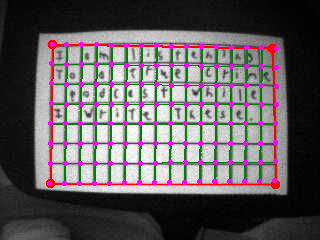

predicted: &


predicted: D


predicted: E


predicted: W


predicted:  


predicted: Y


predicted: +


predicted: X


predicted: *


predicted: X


predicted: X


predicted: !


predicted: X


predicted: J


predicted: |


predicted: Y


predicted: U


predicted: X


predicted: Z


predicted:  


predicted: ?


predicted: [


predicted: X


predicted: ?


predicted:  


predicted: {


predicted: X


predicted: X


predicted: M


predicted: V


predicted: <


predicted: 8


predicted: ?


predicted: W


predicted: [


predicted: X


predicted:  


predicted: {


predicted:  


predicted: Y


predicted: k


predicted: N


predicted: I


predicted: X


predicted: !


predicted: Z


predicted: 9


predicted: W


predicted: *


predicted: {


predicted: Y


predicted: @


predicted:  


predicted: Y


predicted: X


predicted: X


predicted: &


predicted: Z


predicted:  


predicted: U


predicted: S


predicted:  


predicted:  


predicted:  


predicted: X


predicted:  


predicted:  


predicted: {


predicted: J


predicted: {


predicted: 8


predicted: w


predicted: D


predicted: i


predicted: (


predicted: Q


predicted: U


predicted:  


predicted:  


predicted:  


predicted:  


predicted:  


predicted: T


predicted: S


predicted: U


predicted: S


predicted: 3


predicted: i


predicted: i


predicted: 1


predicted: R


predicted: R


predicted:  


predicted: T


predicted: Q


predicted: Q


predicted: D


predicted: T


predicted: (


predicted: $


predicted: 1


predicted: i


predicted: F


predicted: 1


predicted: r
&DEW Y+X*XX!XJ|YUXZ ?[X? {XXMV<8?W[X { YkNIX!Z9W*{Y@ YXX&Z US   X  {J{8wDi(QU     TSUS3ii1RR TQQDT($1iF1r


In [107]:
myImg = Image.open('../Traing Data Preprocessing/Training Data/grid/sample_4.jpg').convert('RGB')

imgs = SliceImage(myImg, 52, 44, 272, 48, 50, 183, 275, 184)

text = DetectChars(imgs)

print (text)

In [51]:
testChar = Image.open('../Traing Data Preprocessing/Training Data/Testing/test_0.png').convert('RGB')
c = PredictChar(testChar)
print(c)

Z
